In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1-初探数据

先加载训练数据，然后查看一下数据格式

In [9]:
data_train = pd.read_csv('data/train.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


我们看到，总共有12列，其中Survived字段表示的是该乘客是否获救，其余都是乘客的个人信息，包括：

| 字段名 | 含义 |
| ------ | ------ |
| PassengerId | 乘客ID |
| Pclass | 乘客等级(1/2/3等舱位)|
| Name | 乘客姓名|
| Sex | 性别|
| Age | 年龄|
| SibSp | 堂兄弟/妹个数|
| Parch | 父母与小孩个数|
| Ticket | 船票信息|
| Fare | 票价|
| Cabin | 客舱|
| Embarked | 登船港口|

训练数据中总共有891名乘客，但是很不幸，我们有些属性的数据不全：
- Age（年龄）属性只有714名乘客有记录 
- Cabin（客舱）更是只有204名乘客是已知的


### 2-数据初步分析
每个乘客都这么多属性，那我们咋知道哪些属性更有用，而又应该怎么用它们。我们再深入一点来看看我们的数据，看看每个/多个 属性和最后的Survived之间有着什么样的关系呢。

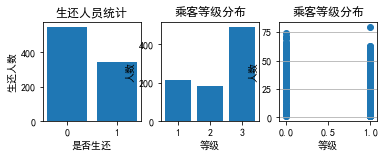

In [23]:
plt.rcParams['font.sans-serif'] = ['SimHei']
fig = plt.figure()
# 生还人数统计
ax1 = fig.add_subplot(231)
suvived_count = data_train['Survived'].value_counts()
plt.bar(suvived_count.index,suvived_count)
ax1.set_title('生还人员统计')
ax1.set_xlabel('是否生还')
ax1.set_ylabel('生还人数')

# 乘客等级分布
ax2 = fig.add_subplot(232)
pclass_count = data_train['Pclass'].value_counts()
plt.bar(pclass_count.index,pclass_count)
ax2.set_title('乘客等级分布')
ax2.set_xlabel('等级')
ax2.set_ylabel('人数')

# 乘客等级分布
ax3 = fig.add_subplot(233)
plt.scatter(data_train['Survived'],data_train['Age'])
plt.grid(b=True, which='major', axis='y') 
ax3.set_title('乘客等级分布')
ax3.set_xlabel('等级')
ax3.set_ylabel('人数')

plt.show()